<a href="https://colab.research.google.com/github/minhnguyen220104/Skin-Cancer-Classification/blob/main/IE0005_Final_Project_Skin_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IE0005 Final Project: Skin Cancer Classification

### Team Members: Liw Jun Le, Nguyen Tuan Minh, Tan Peng Yee, Tan Yinyu

### Dataset used: https://www.kaggle.com/datasets/farjanakabirsamanta/skin-cancer-dataset

### Problem description:  
Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images.

We tackle this problem by releasing the HAM10000 ("Human Against Machine with 10000 training images") dataset. We collected dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions:

**akiec**: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

**bcc**: Basal cell carcinoma

**bkl**: Benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses

**df**: Dermatofibroma

**mel**: Melanoma

**nv**: Melanocytic nevi

**vasc**: Vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage

More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.




## 1. Import necessary modules/libraries and dataset

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Install the Kaggle command-line tool
!pip install -q kaggle

In [ ]:
# Upload Kaggle API Key to Colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ngtminh","key":"2e9aa66256ead50cdbf258d78be73145"}'}

In [ ]:
# Set Up Kaggle Configuration
!mkdir ~/.kaggle # Creates a '.kaggle' directory in home directory
!cp kaggle.json  ~/.kaggle/ # Copy the Kaggle API key to the '.kaggle' in home directory
!chmod 600 ~/.kaggle/kaggle.json # Set the file permissions for the Kaggle API key

In [ ]:
# Download the Dataset
!kaggle datasets download -d farjanakabirsamanta/skin-cancer-dataset

100% 2.58G/2.58G [02:02<00:00, 23.8MB/s]
100% 2.58G/2.58G [02:02<00:00, 22.7MB/s]


In [ ]:
# Extract Dataset
!mkdir skin_cancer # Create a new directory named 'skin_cancer'
!unzip skin-cancer-dataset.zip -d skin_cancer # Unzips the contents of the dataset zip file into directory created above

Streaming output truncated to the last 5000 lines.
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029321.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029322.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029323.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029324.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029325.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029326.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029327.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029328.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029329.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029330.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029331.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029332.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029333.jpg  
  inflating: skin_cancer/Skin Cancer/Skin Cancer/ISIC_0029334.jpg

## 2. Exploratory Data Analysis / Visualization

In [ ]:
# Read the CSV file and display the first 5 rows of the DataFrame
skin_df = pd.read_csv("/content/skin_cancer/HAM10000_metadata.csv")
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# Calculate class counts
class_counts = skin_df['dx'].value_counts()

# Define label dictionary
label_dict = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

# Calculate class weights
class_weights = {label_dict[key]: (1 / val) * (skin_df.shape[0] / 2.0) for key, val in class_counts.items()}
print(class_weights)

# Check class distribution
class_counts = skin_df['dx'].value_counts()
print(class_counts)

{5: 0.7468307233407905, 4: 4.499101527403415, 2: 4.556414922656961, 1: 9.742217898832685, 0: 15.313455657492355, 6: 35.264084507042256, 3: 43.54347826086956}
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


<Axes: >

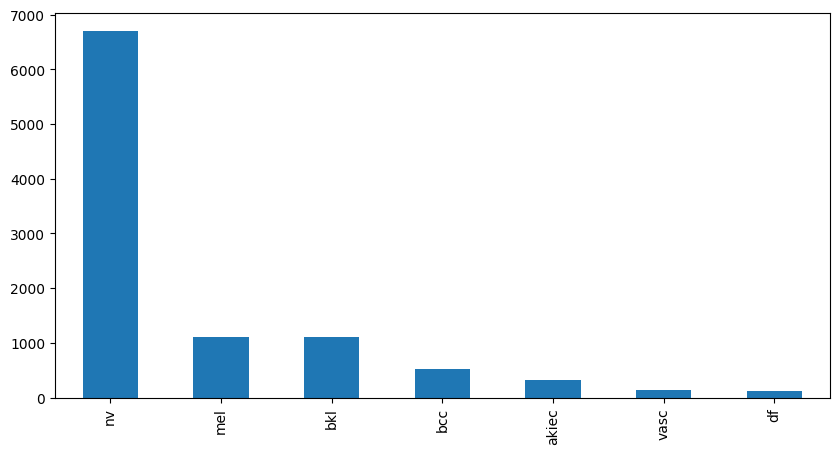

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)

## 3. Preparation of Dataset

In [ ]:
# Data Cleaning
skin_df.isnull().sum() # Check null values in the Dataset

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [ ]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True) # Fill the null values by their mean
skin_df.isnull().sum() # Check result

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [ ]:
# Drop the unwanted columns and display
skinImg_df = skin_df.drop(['lesion_id',  'dx_type', 'age', 'sex', 'localization'], axis=1)
skinImg_df

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl
...,...,...
10010,ISIC_0033084,akiec
10011,ISIC_0033550,akiec
10012,ISIC_0033536,akiec
10013,ISIC_0032854,akiec


In [ ]:
# Define the desired max samples per class
desired_max_count = 115

# Split the classes into two groups
classes_to_resample = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc']
classes_to_keep = ['df']

# Create a DataFrame to store balanced data
balanced_data = pd.DataFrame(columns=['image_id', 'dx'])

# Apply resampling for classes that need it
for class_name in classes_to_resample:
    # Filter data for the current class
    class_data = skinImg_df[skinImg_df['dx'] == class_name]

    # If the class has more than the desired maximum, randomly select 300 samples
    if len(class_data) > desired_max_count:
        selected_samples = random.sample(class_data.index.tolist(), desired_max_count)
        class_data = class_data.loc[selected_samples]

    # Combine the resampled data with the balanced_data DataFrame
    balanced_data = pd.concat([balanced_data, class_data], ignore_index=True)

# Keep the classes that don't need resampling
for class_name in classes_to_keep:
    class_data = skinImg_df[skinImg_df['dx'] == class_name]
    balanced_data = pd.concat([balanced_data, class_data], ignore_index=True)

# The balanced_data DataFrame now contains the balanced dataset
balanced_data
class_counts = balanced_data['dx'].value_counts()
print(class_counts)

nv       115
mel      115
bkl      115
bcc      115
akiec    115
vasc     115
df       115
Name: dx, dtype: int64


In [ ]:
# Preprocessing (CLEANER CODE :))
def preprocess_image(image_path, image_size=128):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB :)
    img = cv2.resize(img, (image_size, image_size))
    return img

# Load and preprocess images
X = []
y = []
label_dict = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

for index, row in balanced_data.iterrows():
    if index % 100 == 0:
        print(f"Processing image {index}")
    img_id = row['image_id'] + '.jpg'
    img_path = os.path.join('/content/skin_cancer/Skin Cancer/Skin Cancer', img_id)
    if os.path.exists(img_path):
        img = preprocess_image(img_path)
        X.append(img)
        y.append(label_dict[row['dx']])
    else:
        print(f"Image file does not exist: {img_id}")

X = np.array(X, dtype=np.float32) / 255.0
y = to_categorical(np.array(y), num_classes=7)

Processing image 0
Processing image 100
Processing image 200
Processing image 300
Processing image 400
Processing image 500
Processing image 600
Processing image 700
Processing image 800


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Data Augmentation with more parameters :)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

# Create the training generator
train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Create the validation generator
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(X_test, y_test, batch_size=32)

## 4. Model Creation

In [ ]:
# Model Creation with Fine-tuning :)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)  # Increased the number of neurons
x = Dense(128, activation='relu')(x)  # Additional dense layer
x = Dense(128, activation='relu')(x)  # Additional dense layer
x = Dense(64, activation='relu')(x)  # Additional dense layer
output = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Callbacks :)
# Save Best Model
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# Prevent Overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Adjust Learning Rate during Training
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

In [ ]:
# Unfreeze some layers of the base model for fine-tuning :)
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [ ]:
# Model compilation :)
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

## Model Fitting for training

In [ ]:
# Train the model with class weights and larger batch size :)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.8820 - accuracy: 0.2112

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 49s 380ms/step - loss: 1.8820 - accuracy: 0.2112 - val_loss: 1.9878 - val_accuracy: 0.1304 - lr: 1.0000e-04
Epoch 2/10
21/21 [==============================] - 10s 478ms/step - loss: 1.6252 - accuracy: 0.3696 - val_loss: 2.0215 - val_accuracy: 0.1366 - lr: 1.1220e-04
Epoch 3/10
21/21 [==============================] - 4s 187ms/step - loss: 1.3855 - accuracy: 0.4876 - val_loss: 2.0793 - val_accuracy: 0.1304 - lr: 1.2589e-04
Epoch 4/10
21/21 [==============================] - 4s 188ms/step - loss: 1.2889 - accuracy: 0.5000 - val_loss: 2.1206 - val_accuracy: 0.1242 - lr: 1.4125e-04
Epoch 5/10
21/21 [==============================] - 4s 193ms/step - loss: 1.3218 - accuracy: 0.5248 - val_loss: 2.2634 - val_accuracy: 0.1242 - lr: 1.5849e-04
Epoch 6/10
21/21 [==============================] - 10s 517ms/step - loss: 1.2049 - accuracy: 0.5264 - val_loss: 2.1650 - val_accuracy: 0.1677 - lr: 1.7783e-04
Epoch 7/10
21/21 [==============================] - 4s

## 6. Prediction of test data

In [ ]:
predicted_classes

NameError: ignored

In [ ]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [ ]:
# Predict on test data :)
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=label_dict.keys(), output_dict=True)
print(report)

6/6 [==============================] - 1s 35ms/step
{'akiec': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 22}, 'bcc': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 22}, 'bkl': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20}, 'df': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 29}, 'mel': {'precision': 0.12422360248447205, 'recall': 1.0, 'f1-score': 0.22099447513812154, 'support': 20}, 'nv': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 27}, 'vasc': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21}, 'accuracy': 0.12422360248447205, 'macro avg': {'precision': 0.01774622892635315, 'recall': 0.14285714285714285, 'f1-score': 0.03157063930544594, 'support': 161}, 'weighted avg': {'precision': 0.01543150341422013, 'recall': 0.12422360248447205, 'f1-score': 0.02745272983082255, 'support': 161}}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


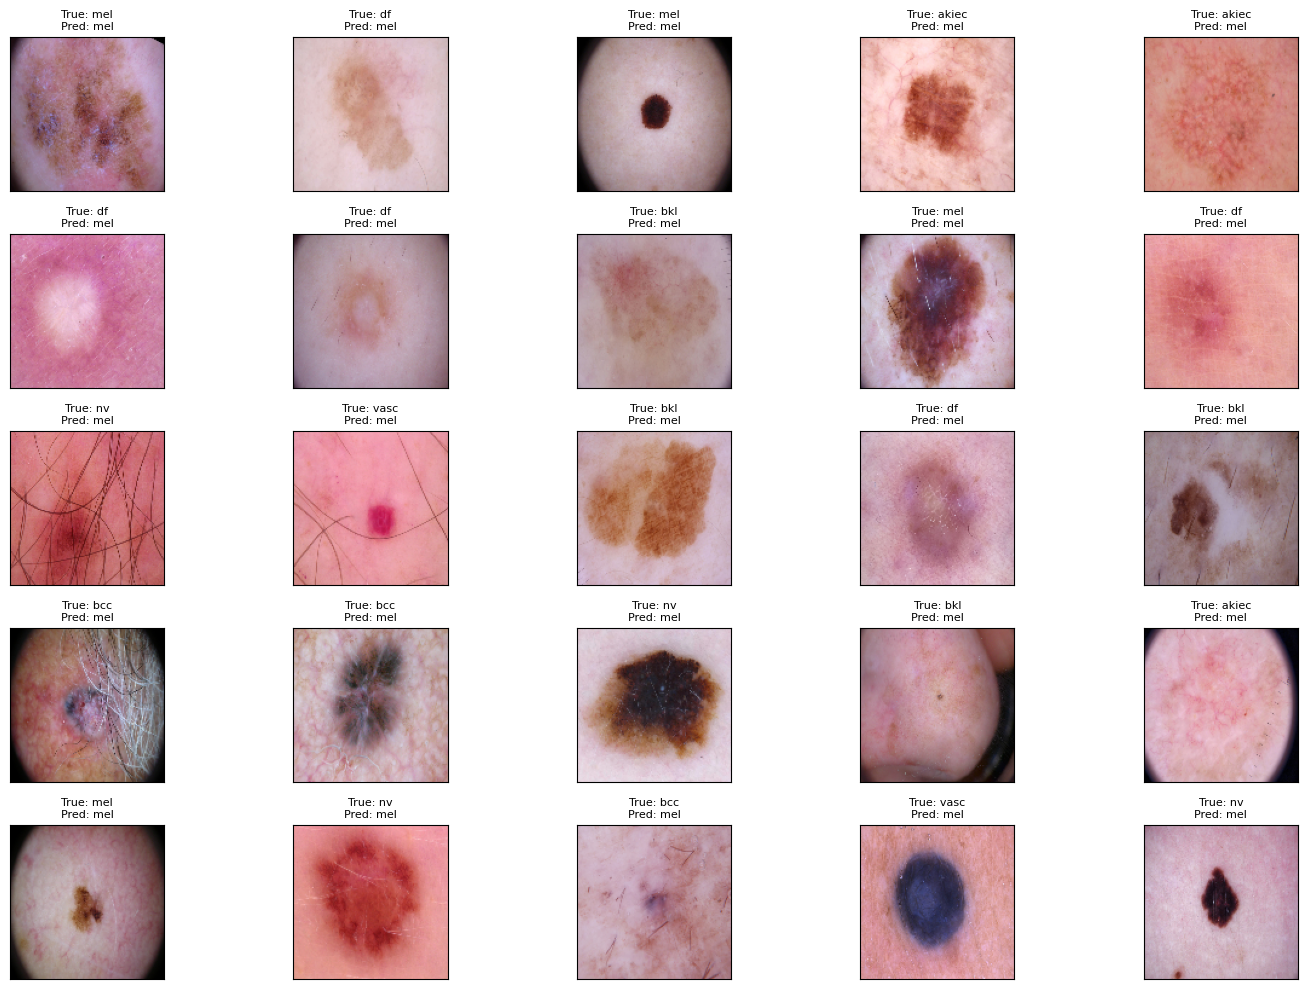

In [ ]:
# Visualizing Predictions :)
def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(15, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f"True: {list(label_dict.keys())[true_labels[i]]}\nPred: {list(label_dict.keys())[predicted_labels[i]]}", fontsize=8)
    plt.tight_layout()
    plt.show()

# Plot some test images along with the true and predicted labels
plot_images(X_test[:25], true_classes[:25], predicted_classes[:25])

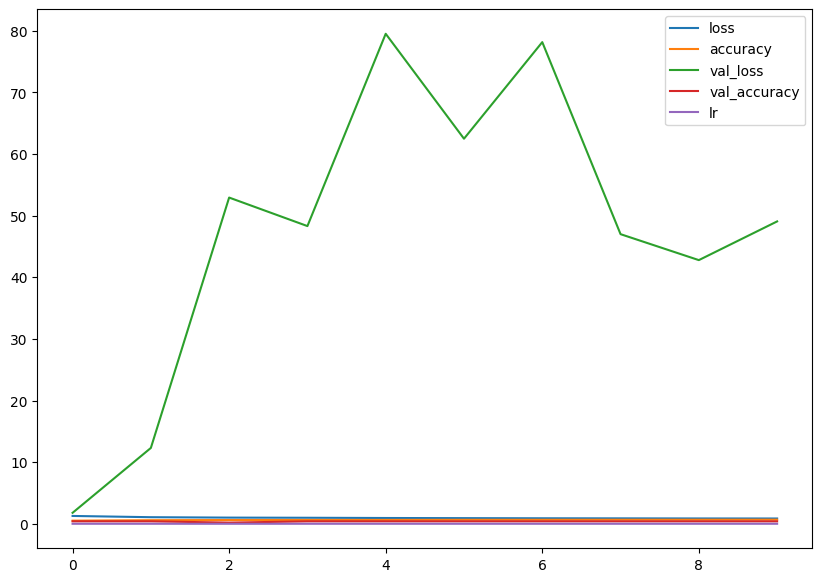

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10, 7));